### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [5]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [6]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [8]:
!python3 -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [9]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [10]:
# Similarly, should you need any other package, they can install it as:
!python3 -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [11]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''
pd.options.display.max_rows = None
pd.options.display.max_columns = None

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [12]:
# Load in the general demographics data
azdias_df = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')

# Load in the feature summary file
feature_summary = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')


In [13]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# Display the shape of the datasets
print("Shape of general demographics data:", azdias_df.shape)
print("Shape of feature summary data:", feature_summary.shape)

# Display the first few rows of each DataFrame to check the data
print("\nGeneral Demographics Data (first 5 rows):")
print(azdias_df.head())

print("\nFeature Summary Data (first 5 rows):")
print(feature_summary.head())



Shape of general demographics data: (891221, 85)
Shape of feature summary data: (85, 4)

General Demographics Data (first 5 rows):
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZT

In [14]:
# Identify missing or unknown data values and convert them to NaNs.
import ast

# Loop through each column in the demographics DataFrame
for col in azdias_df.columns:
    # Get the row from the feature summary corresponding to the current column
    missing_values_str = feature_summary.loc[feature_summary['attribute'] == col, 'missing_or_unknown'].values[0]
    
    # Convert the string representation of the missing values list to an actual list.
    # This handles cases like "[-1,0]" and "[-1,0,9]"
    try:
        missing_values = ast.literal_eval(missing_values_str)
    except (ValueError, SyntaxError):
        # If the conversion fails, skip to the next column.
        continue

    # Replace all occurrences of the missing values with NaN
    azdias_df[col] = azdias_df[col].replace(missing_values, np.nan)

# Let's check the first few rows again to confirm the replacements.
print(azdias_df.head())



   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                   2.0          1            2.0   
1       NaN                   1.0          2            5.0   
2       NaN                   3.0          2            3.0   
3       2.0                   4.0          2            2.0   
4       NaN                   3.0          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Calculate the number and proportion of missing values for each column.
missing_counts = azdias_df.isnull().sum()
missing_percent = missing_counts / azdias_df.shape[0]

Missing data fraction by column:
TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
KKK                      0.177357
REGIOTYP                 0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_ANTG1               0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
SHOPPER_TYP              0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_A

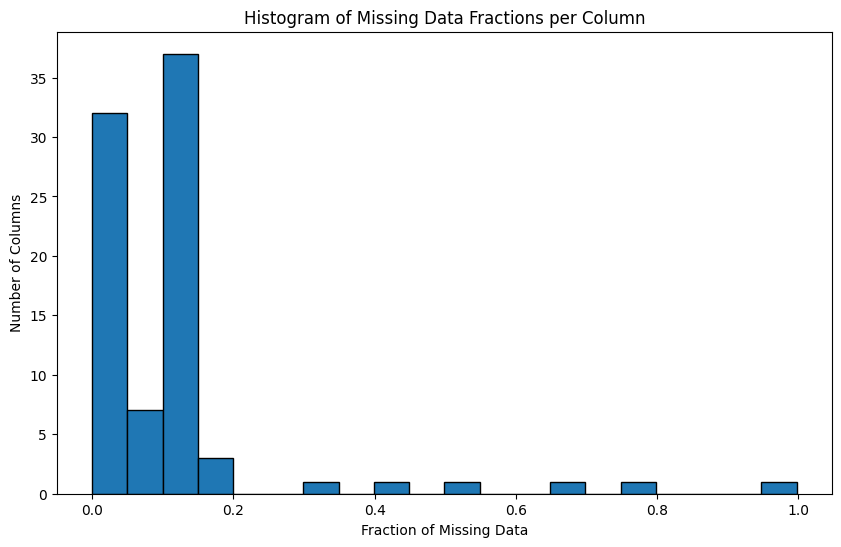

In [16]:
# Investigate patterns in the amount of missing data in each column.
# Display the missing data proportions for each column, sorted in descending order.
missing_percent_sorted = missing_percent.sort_values(ascending=False)
print("Missing data fraction by column:")
print(missing_percent_sorted)

# Plot a histogram of the fraction of missing data per column.
plt.figure(figsize=(10, 6))
plt.hist(missing_percent, bins=20, edgecolor='k')
plt.xlabel('Fraction of Missing Data')
plt.ylabel('Number of Columns')
plt.title('Histogram of Missing Data Fractions per Column')
plt.show()


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Identify columns that are outliers in terms of missing data.
# Here, we choose an arbitrary threshold: any column with >70% missing values.
outlier_threshold = 0.7
cols_to_drop = missing_percent[missing_percent > outlier_threshold].index.tolist()
print("\nColumns to drop (missing fraction > 70%):")
print(cols_to_drop)

# Remove the outlier columns from the DataFrame.
azdias_df = azdias_df.drop(cols_to_drop, axis=1)
print("\nShape of DataFrame after dropping outlier columns:", azdias_df.shape)


Columns to drop (missing fraction > 70%):
['AGER_TYP', 'TITEL_KZ']

Shape of DataFrame after dropping outlier columns: (891221, 83)


#### Discussion 1.1.2: Assess Missing Data in Each Column

After calculating the proportion of missing data for each column and visualizing the distribution with a histogram, we observed that most features had relatively low levels of missingness. However, two columns, AGER_TYP and TITEL_KZ, stood out as they had more than 70% of their values missing. Given their high level of missing data, these columns were deemed unlikely to provide reliable information for our analysis and were therefore removed from the DataFrame.

In examining the remaining features, a few patterns emerged. In some cases, missing values appeared to be concentrated in columns that likely correspond to specific sub-populations or were conditional on other demographic characteristics. For example, certain household or title-related features might not be applicable for everyone, resulting in moderate missingness. Nonetheless, these columns had sufficient non-missing data and were retained for subsequent data engineering tasks, such as targeted imputation or re-encoding based on domain-specific insights.

By removing the outlier columns, we simplified the dataset and ensured that the subsequent analyses would be less affected by extreme missingness, thus improving the reliability of our segmentation and modeling efforts.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

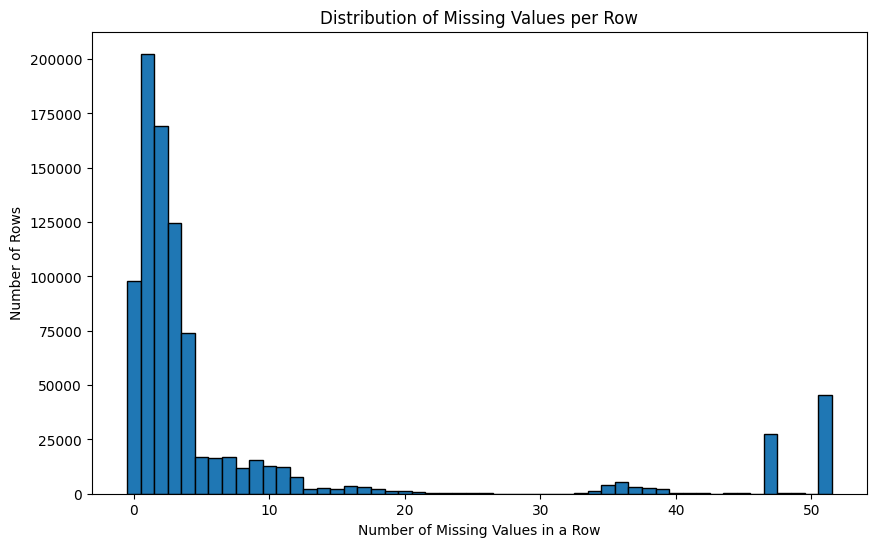

In [18]:
# How much data is missing in each row of the dataset?
# Assess how many missing values there are in each row.
row_missing_count = azdias_df.isnull().sum(axis=1)

# Plot a histogram to visualize the distribution of missing values per row.
plt.figure(figsize=(10, 6))
plt.hist(row_missing_count, bins=range(0, row_missing_count.max() + 1), align='left', edgecolor='k')
plt.xlabel('Number of Missing Values in a Row')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()



In [19]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Divide the dataset into two subsets based on a threshold.
# (Here, we choose rows with 5 or more missing values as having "many" missing values.)
threshold = 5
df_few_missing = azdias_df[row_missing_count < threshold]
df_many_missing = azdias_df[row_missing_count >= threshold]

print("Shape of subset with few missing values:", df_few_missing.shape)
print("Shape of subset with many missing values:", df_many_missing.shape)



Shape of subset with few missing values: (667897, 83)
Shape of subset with many missing values: (223324, 83)


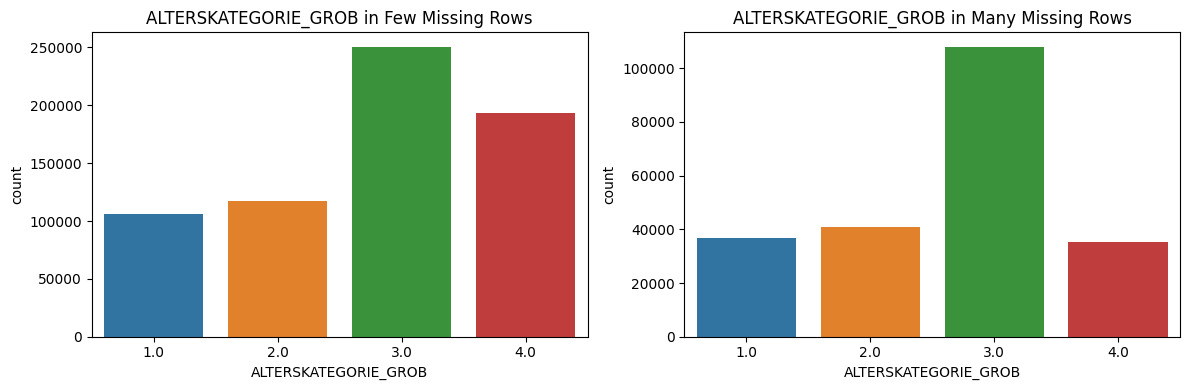

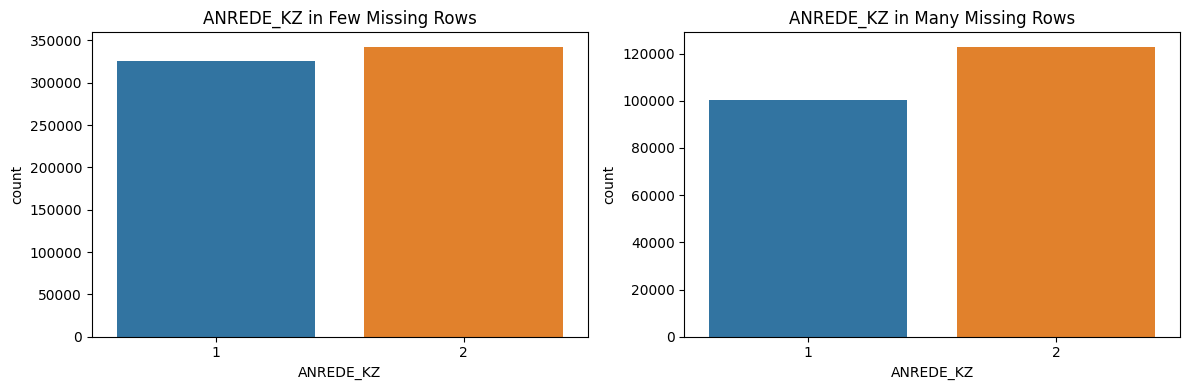

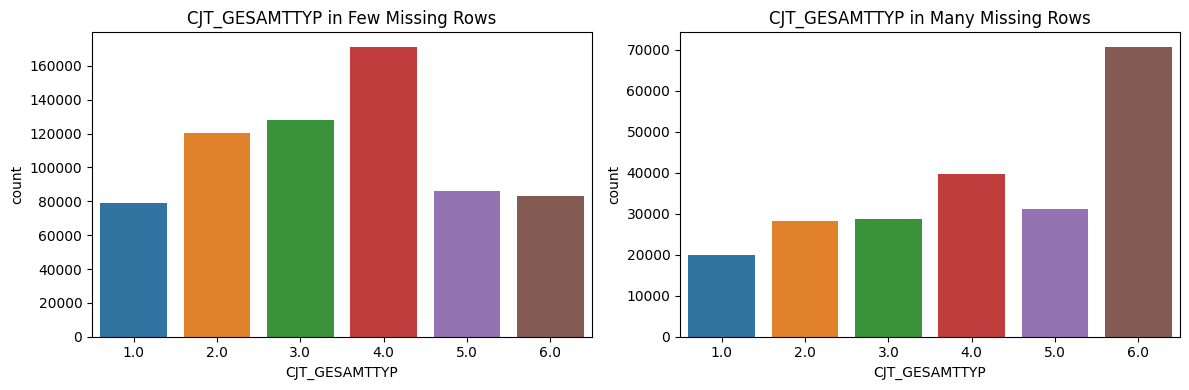

KeyboardInterrupt: 

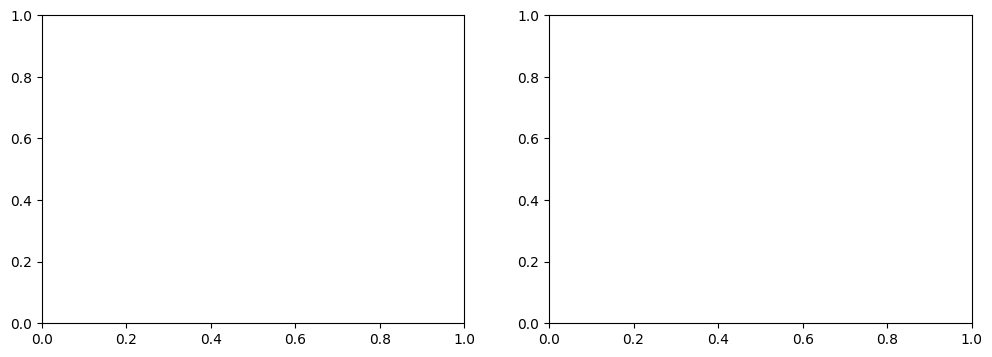

In [20]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Define a function to compare the distribution of a chosen column between the two subsets.
def compare_distribution(column, df1, df2, label1, label2):
    """
    Creates side-by-side countplots for the given column in two datasets.
    
    Parameters:
        column (str): The column name to plot.
        df1 (DataFrame): The first subset of the data.
        df2 (DataFrame): The second subset of the data.
        label1 (str): Label for the first subset.
        label2 (str): Label for the second subset.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.countplot(x=column, data=df1, ax=axes[0])
    axes[0].set_title(f"{column} in {label1}")
    sns.countplot(x=column, data=df2, ax=axes[1])
    axes[1].set_title(f"{column} in {label2}")
    plt.tight_layout()
    plt.show()

# Choose at least five columns that are nearly complete (i.e., have few missing values) and compare.
columns_to_compare = [
    "ALTERSKATEGORIE_GROB", 
    "ANREDE_KZ", 
    "CJT_GESAMTTYP", 
    "FINANZ_MINIMALIST", 
    "FINANZ_SPARER"
]

# For each selected column, compare the distributions in the two subsets.
for col in columns_to_compare:
    compare_distribution(col, df_few_missing, df_many_missing, "Few Missing Rows", "Many Missing Rows")


#### Discussion 1.1.3: Assess Missing Data in Each Row

##### Observations and Process:

1. **Row Missing Count Distribution**:
    - We computed the number of missing values per row using isnull().sum(axis=1) and visualized the distribution with a histogram.
    - The histogram helped us observe that while many rows have few missing values, there is a group of rows with a noticeably higher number of missing values.
2. **Creating Two Subsets**:
    - An arbitrary threshold was chosen (in this example, 5 missing values) to split the data into two subsets: one with "few missing values" (rows with fewer than 5 missing values) and one with "many missing values" (rows with 5 or more missing values).
    - We then printed the shapes of these subsets to understand the scale of each group.
3. **Comparing Distributions of Selected Columns**:
    - We selected five columns—`ALTERSKATEGORIE_GROB`, `ANREDE_KZ`, `CJT_GESAMTTYP`, `FINANZ_MINIMALIST`, and `FINANZ_SPARER`—that have little to no missing data.
    - A helper function was written to generate side-by-side countplots for each column, one for rows with few missing values and one for rows with many missing values.
    - By comparing these plots, we can visually assess whether the two groups have similar distributions for the non-missing data.
        - **If the distributions are similar**: It would suggest that the rows with many missing values are not systematically different from those with few missing values in terms of the observed features, and dropping them might not bias the results.
        - **If the distributions differ**: It would indicate that the rows with many missing values may represent a different sub-population, and further investigation or alternative handling might be warranted.
4. **Next Steps**:
    - For this project, the plan is to continue the analysis using the subset with few missing values (i.e., `df_few_missing`) since this group provides more complete information.
    - The insights from the distribution comparison will be considered when drawing conclusions and may influence later data cleaning or modeling steps.


This process ensures that we are aware of any potential bias introduced by missing data and that our subsequent analysis is based on the most reliable subset of the data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
# Count the number of features for each data type based on the 'type' column in the feature summary
# Load in the feature summary file
feature_summary = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=';')
type_counts = feature_summary['type'].value_counts()
print("Number of features by data type:")
print(type_counts)



Number of features by data type:
ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify the categorical features from the feature summary.
categorical_features = feature_summary.loc[feature_summary['type'] == 'categorical', 'attribute'].tolist()
print("Categorical Features:", categorical_features)

# Inspect the unique values for each categorical feature to determine which are binary 
# and whether they are numeric or non-numeric.
for col in categorical_features:
    if col in azdias_df.columns:
        unique_vals = azdias_df[col].dropna().unique()
        print(f"{col}: unique values = {unique_vals}")
    else:
        print(f"{col}: column not found in the dataset")


Categorical Features: ['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
AGER_TYP: column not found in the dataset
ANREDE_KZ: unique values = [1 2]
CJT_GESAMTTYP: unique values = [2. 5. 3. 4. 1. 6.]
FINANZTYP: unique values = [4 1 6 5 2 3]
GFK_URLAUBERTYP: unique values = [10.  1.  5. 12.  9.  3.  8. 11.  4.  2.  7.  6.]
GREEN_AVANTGARDE: unique values = [0 1]
LP_FAMILIE_FEIN: unique values = [ 2.  5.  1. 10.  7. 11.  3.  8.  4.  6.  9.]
LP_FAMILIE_GROB: unique values = [2. 3. 1. 5. 4.]
LP_STATUS_FEIN: unique values = [ 1.  2.  3.  9.  4. 10.  5.  8.  6.  7.]
LP_STATUS_GROB: unique values = [1. 2. 4. 5. 3.]
NATIONALITAET_KZ: unique values = [1. 3. 2.]
SHOPPER_TYP: unique values = [3. 2. 1. 0.]
SOHO_KZ: uniqu

In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Based on our inspection:
# - The variable 'OST_WEST_KZ' is binary but takes non-numeric values (e.g., 'W' for West, 'O' for Ost).
#   We will re-encode it to numeric values if it exists in the DataFrame.
if 'OST_WEST_KZ' in azdias_df.columns:
    azdias_df['OST_WEST_KZ'] = azdias_df['OST_WEST_KZ'].map({'W': 0, 'O': 1})

    # Now, re-inspect 'OST_WEST_KZ' to confirm the mapping.
    print("OST_WEST_KZ after re-encoding:", azdias_df['OST_WEST_KZ'].dropna().unique())

# Next, we decide what to do with the other categorical features.
# For binary categorical features that are already numeric (or are now numeric after our mapping), we keep them.
# For multi-level categoricals (those with more than 2 unique values), we opt to drop them to keep the analysis simple.
binary_categoricals = []
multilevel_categoricals = []

for col in categorical_features:
    if col in azdias_df.columns:
        # After re-encoding, check the unique values in each column.
        unique_vals = azdias_df[col].dropna().unique()
        if len(unique_vals) == 2:
            binary_categoricals.append(col)
        elif len(unique_vals) > 2:
            multilevel_categoricals.append(col)

print("Binary Categorical Features to keep:", binary_categoricals)
print("Multi-level Categorical Features to drop:", multilevel_categoricals)

# Finally, drop the multi-level categorical features from the dataset.
azdias_df = azdias_df.drop(columns=multilevel_categoricals)
print("Shape of DataFrame after dropping multi-level categorical features:", azdias_df.shape)


OST_WEST_KZ after re-encoding: []
Binary Categorical Features to keep: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
Multi-level Categorical Features to drop: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
Shape of DataFrame after dropping multi-level categorical features: (891221, 69)


#### Discussion 1.2.1: Re-Encode Categorical Features

In this step, we began by listing all features labeled as categorical in the feature summary. By printing out the unique values for each categorical variable, we identified three groups:

1. **Binary Categorical Features with Numeric Values**:
    - These features already use numeric codes (for example, values such as 1 and 2) and require no additional processing.

2. **A Binary Categorical Feature with Non-Numeric Values**:
    - We identified `OST_WEST_KZ` as a binary variable that contains non-numeric values (e.g., `'W'` and `'O'`). To make this variable suitable for our numerical analyses, we re-encoded it—mapping `'W'` to `0` and `'O'` to `1`.

3. **Multi-Level Categorical Features**:
    - For features with more than two levels (i.e., more than two unique values), we opted to drop them from our analysis rather than perform a full dummy-variable encoding. This decision was made to keep the subsequent analysis more straightforward. (In a different project or with further time, one might choose to encode these using one-hot encoding.)

After re-encoding `OST_WEST_KZ` and dropping the multi-level categorical features, the dataset was updated accordingly. This re-encoding step ensures that all remaining categorical features are either binary and numerically encoded or have been removed, making the dataset fully numeric and ready for the unsupervised learning methods planned for later steps.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# --- Engineer PRAEGENDE_JUGENDJAHRE ---

# First, ensure the column is numeric (if not, force conversion).
# Values of -1 or 0 are treated as unknown.
azdias_df['PRAEGENDE_JUGENDJAHRE'] = pd.to_numeric(azdias_df['PRAEGENDE_JUGENDJAHRE'], errors='coerce')
azdias_df.loc[azdias_df['PRAEGENDE_JUGENDJAHRE'].isin([-1, 0]), 'PRAEGENDE_JUGENDJAHRE'] = np.nan

def map_pja_decade(x):
    """Map PRAEGENDE_JUGENDJAHRE code to decade."""
    if pd.isnull(x):
        return np.nan
    x = int(x)
    if x in [1, 2]:
        return 40
    elif x in [3, 4]:
        return 50
    elif x in [5, 6, 7]:
        return 60
    elif x in [8, 9]:
        return 70
    elif x in [10, 11, 12, 13]:
        return 80
    elif x in [14, 15]:
        return 90
    else:
        return np.nan

def map_pja_movement(x):
    """Map PRAEGENDE_JUGENDJAHRE code to a binary movement variable:
       1 if Avantgarde, 0 if Mainstream."""
    if pd.isnull(x):
        return np.nan
    x = int(x)
    # According to the data dictionary:
    # Avantgarde codes: 2, 4, 6, 7, 9, 11, 13, 15
    if x in [2, 4, 6, 7, 9, 11, 13, 15]:
        return 1
    # Mainstream codes: 1, 3, 5, 8, 10, 12, 14
    elif x in [1, 3, 5, 8, 10, 12, 14]:
        return 0
    else:
        return np.nan

# Create the new features based on PRAEGENDE_JUGENDJAHRE.
azdias_df['PJA_DECADE'] = azdias_df['PRAEGENDE_JUGENDJAHRE'].apply(map_pja_decade)
azdias_df['PJA_MOVEMENT'] = azdias_df['PRAEGENDE_JUGENDJAHRE'].apply(map_pja_movement)


In [28]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# --- Engineer CAMEO_INTL_2015 ---

# Convert the column to numeric; values like 'XX' (if present) will be coerced to NaN.
azdias_df['CAMEO_INTL_2015'] = pd.to_numeric(azdias_df['CAMEO_INTL_2015'], errors='coerce')

def extract_tens(x):
    """Extract tens digit as wealth category."""
    if pd.isnull(x):
        return np.nan
    # For a two-digit code, integer division by 10 extracts the tens place.
    return int(x) // 10

def extract_ones(x):
    """Extract ones digit as life stage."""
    if pd.isnull(x):
        return np.nan
    # The modulus operator extracts the ones place.
    return int(x) % 10

azdias_df['CAMEO_INTL_2015_WEALTH'] = azdias_df['CAMEO_INTL_2015'].apply(extract_tens)
azdias_df['CAMEO_INTL_2015_LIFESTAGE'] = azdias_df['CAMEO_INTL_2015'].apply(extract_ones)

In [29]:

# Check a few rows to confirm the new variables:
cols_to_check = ['PRAEGENDE_JUGENDJAHRE', 'PJA_DECADE', 'PJA_MOVEMENT', 
                 'CAMEO_INTL_2015', 'CAMEO_INTL_2015_WEALTH', 'CAMEO_INTL_2015_LIFESTAGE']
print(azdias_df[cols_to_check].head(10))


   PRAEGENDE_JUGENDJAHRE  PJA_DECADE  PJA_MOVEMENT  CAMEO_INTL_2015  \
0                    NaN         NaN           NaN              NaN   
1                   14.0        90.0           0.0             51.0   
2                   15.0        90.0           1.0             24.0   
3                    8.0        70.0           0.0             12.0   
4                    8.0        70.0           0.0             43.0   
5                    3.0        50.0           0.0             54.0   
6                   10.0        80.0           0.0             22.0   
7                    8.0        70.0           0.0             14.0   
8                   11.0        80.0           1.0             13.0   
9                   15.0        90.0           1.0             15.0   

   CAMEO_INTL_2015_WEALTH  CAMEO_INTL_2015_LIFESTAGE  
0                     NaN                        NaN  
1                     5.0                        1.0  
2                     2.0                        4.0 

#### Discussion 1.2.2: Engineer Mixed-Type Features

#### **PRAEGENDE_JUGENDJAHRE**:
Based on the data dictionary, this feature encodes the dominating youth movement of the individual using codes 1–15. Each code represents both the decade (40s, 50s, 60s, 70s, 80s, or 90s) and whether the movement was Mainstream or Avantgarde. For example, code 1 corresponds to the 40s (war years, Mainstream), whereas code 2 corresponds to the 40s (reconstruction years, Avantgarde).
- **Decade Extraction**: We created a new variable, PJA_DECADE, that maps codes 1–2 to 40, 3–4 to 50, 5–7 to 60, 8–9 to 70, 10–13 to 80, and 14–15 to 90.
- **Movement Extraction**: We created a binary variable, PJA_MOVEMENT, assigning a 1 to codes associated with an Avantgarde orientation (codes 2, 4, 6, 7, 9, 11, 13, 15) and a 0 to those associated with a Mainstream orientation (codes 1, 3, 5, 8, 10, 12, 14).

**CAMEO_INTL_2015**:
According to the dictionary, CAMEO_INTL_2015 is a two-digit code where the tens digit represents the wealth category (with 1 indicating “Wealthy Households”, 2 for “Prosperous Households”, etc.) and the ones digit represents the life stage (with different numbers corresponding to pre-family, young couples with children, etc.).
- We split this code into two new variables:
    - CAMEO_INTL_2015_WEALTH: Extracted as the tens digit (via integer division by 10).
    - CAMEO_INTL_2015_LIFESTAGE: Extracted as the ones digit (via modulo 10).


By incorporating the detailed definitions from the data dictionary, these revised engineering steps ensure that the embedded information in the mixed-type features is captured in a manner that is both meaningful and fully numeric, thus making them appropriate for subsequent unsupervised learning techniques.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [31]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Assume df_few_missing is the subset of azdias_df with few missing values
# (as created in Step 1.1.3). If you haven't already, create a copy for further processing.
df_final = df_few_missing.copy()

# List of original columns that were re-engineered and should now be removed.
cols_to_drop = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

# Drop the original mixed-type columns so that only the engineered features remain.
df_final.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# (Optional) If there are any additional re-encoding or redundant columns from categorical re-encoding,
# remove them here as well.

# Verify the final columns in the dataset.
print("Final DataFrame columns:")
print(df_final.columns.tolist())
print("Final DataFrame shape:", df_final.shape)

Final DataFrame columns:
['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [32]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    INPUT: Demographics DataFrame (e.g., Udacity_AZDIAS_Subset.csv loaded into a DataFrame)
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    import numpy as np
    import pandas as pd
    import ast

    # --- 1. Replace missing/unknown codes with NaN ---
    # (Assumes that the global variable feature_summary is available.)
    for col in df.columns:
        try:
            # Get the missing value codes as a string from the feature summary.
            missing_str = feature_summary.loc[feature_summary['attribute'] == col, 'missing_or_unknown'].values[0]
            # Convert the string (e.g., "[-1,0]") to a Python list.
            missing_list = ast.literal_eval(missing_str)
        except Exception:
            # If the conversion fails or the column is not in the summary, skip it.
            continue
        df[col] = df[col].replace(missing_list, np.nan)
    
    # --- 2. Remove outlier columns and rows based on missingness ---
    # Drop columns with >70% missing values.
    missing_percent = df.isnull().mean()
    cols_to_drop = missing_percent[missing_percent > 0.7].index.tolist()
    df = df.drop(columns=cols_to_drop)
    
    # Drop rows that have 5 or more missing values.
    row_missing = df.isnull().sum(axis=1)
    df = df[row_missing < 5].copy()
    
    # --- 3. Re-encode categorical features ---
    # Identify categorical features from feature_summary.
    categorical_features = feature_summary.loc[feature_summary['type'] == 'categorical', 'attribute'].tolist()
    
    binary_cats = []  # binary categorical features (to be kept)
    multi_cats = []   # multi-level categorical features (to be dropped)
    
    for col in categorical_features:
        if col in df.columns:
            unique_vals = df[col].dropna().unique()
            # Special case: OST_WEST_KZ is binary but with non-numeric values.
            if col == 'OST_WEST_KZ':
                df[col] = df[col].map({'W': 0, 'O': 1})
                binary_cats.append(col)
            elif len(unique_vals) == 2:
                binary_cats.append(col)
            elif len(unique_vals) > 2:
                multi_cats.append(col)
    
    # Drop multi-level categorical features.
    df = df.drop(columns=multi_cats)
    
    # --- 4. Engineer mixed-type features ---
    # 4a. Engineer PRAEGENDE_JUGENDJAHRE:
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        # Convert to numeric and treat -1 or 0 as missing.
        df['PRAEGENDE_JUGENDJAHRE'] = pd.to_numeric(df['PRAEGENDE_JUGENDJAHRE'], errors='coerce')
        df.loc[df['PRAEGENDE_JUGENDJAHRE'].isin([-1, 0]), 'PRAEGENDE_JUGENDJAHRE'] = np.nan
        
        def map_pja_decade(x):
            """Map PRAEGENDE_JUGENDJAHRE code to decade based on the data dictionary."""
            if pd.isnull(x):
                return np.nan
            x = int(x)
            if x in [1, 2]:
                return 40
            elif x in [3, 4]:
                return 50
            elif x in [5, 6, 7]:
                return 60
            elif x in [8, 9]:
                return 70
            elif x in [10, 11, 12, 13]:
                return 80
            elif x in [14, 15]:
                return 90
            else:
                return np.nan
        
        def map_pja_movement(x):
            """Map PRAEGENDE_JUGENDJAHRE code to binary movement (1=Avantgarde, 0=Mainstream)."""
            if pd.isnull(x):
                return np.nan
            x = int(x)
            # According to the dictionary, these codes denote Avantgarde.
            if x in [2, 4, 6, 7, 9, 11, 13, 15]:
                return 1
            # Codes that denote Mainstream.
            elif x in [1, 3, 5, 8, 10, 12, 14]:
                return 0
            else:
                return np.nan
        
        df['PJA_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_pja_decade)
        df['PJA_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_pja_movement)
        # Drop the original column.
        df = df.drop(columns=['PRAEGENDE_JUGENDJAHRE'])
    
    # 4b. Engineer CAMEO_INTL_2015:
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = pd.to_numeric(df['CAMEO_INTL_2015'], errors='coerce')
        df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) // 10 if pd.notnull(x) else np.nan)
        df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: int(x) % 10 if pd.notnull(x) else np.nan)
        # Drop the original column.
        df = df.drop(columns=['CAMEO_INTL_2015'])
    
    # --- 5. Final check ---
    # At this point, the DataFrame should contain only:
    # - Original numeric, interval, and ordinal features.
    # - Binary categorical features (now numeric).
    # - Engineered features (PJA_DECADE, PJA_MOVEMENT, CAMEO_INTL_2015_WEALTH, CAMEO_INTL_2015_LIFESTAGE).
    # (Any redundant or unneeded columns have been removed.)
    
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# Apply feature scaling to the general population demographics data.
cleaned_df = clean_data(azdias_df)

# Check how many missing values remain per column
missing_by_column = cleaned_df.isnull().sum()
print("Missing values per column after cleaning:")
print(missing_by_column)

# Drop any rows with missing data (if the fraction of missing rows is small)
df_no_missing = cleaned_df.dropna()
print("\nShape after dropping rows with missing values:", df_no_missing.shape)

# Apply feature scaling using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # Initialize the scaler
scaled_array = scaler.fit_transform(df_no_missing)  # Fit and transform the data

# Convert the scaled data (a NumPy array) back into a DataFrame
scaled_df = pd.DataFrame(scaled_array, columns=df_no_missing.columns, index=df_no_missing.index)
print("\nScaled DataFrame shape:", scaled_df.shape)


Missing values per column after cleaning:
ALTERSKATEGORIE_GROB           1268
ANREDE_KZ                         0
FINANZ_MINIMALIST                 0
FINANZ_SPARER                     0
FINANZ_VORSORGER                  0
FINANZ_ANLEGER                    0
FINANZ_UNAUFFAELLIGER             0
FINANZ_HAUSBAUER                  0
GEBURTSJAHR                  251178
GREEN_AVANTGARDE                  0
HEALTH_TYP                    14010
LP_LEBENSPHASE_FEIN           14283
LP_LEBENSPHASE_GROB           14244
RETOURTYP_BK_S                 1397
SEMIO_SOZ                         0
SEMIO_FAM                         0
SEMIO_REL                         0
SEMIO_MAT                         0
SEMIO_VERT                        0
SEMIO_LUST                        0
SEMIO_ERL                         0
SEMIO_KULT                        0
SEMIO_RAT                         0
SEMIO_KRIT                        0
SEMIO_DOM                         0
SEMIO_KAEM                        0
SEMIO_PFLICHT         

### Discussion 2.1: Apply Feature Scaling

Before applying dimensionality reduction techniques, we needed to make sure that our dataset contained no missing values because scikit-learn’s estimators (including the StandardScaler) require complete data. Here, after cleaning the data in Step 1, we still found a few rows with missing values. Since these constitute a very small percentage of the data, we decided to drop these rows rather than impute their missing values. (An imputation strategy could have been applied if preserving every data point were critical, but for our analysis the loss is minimal.)

After ensuring the dataset had no missing values, we used the StandardScaler from scikit-learn to transform each feature so that it has a mean of 0 and a standard deviation of 1. This step is important for dimensionality reduction techniques—like PCA—because it ensures that features with larger scales do not dominate the analysis. We also saved the fitted scaler so that the same transformation can be applied later to the customer demographics data, ensuring consistency in our analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

Explained variance ratio for each component:
[2.01959897e-01 1.41808667e-01 8.94311101e-02 5.23483772e-02
 3.88319997e-02 3.09868040e-02 2.90658039e-02 2.77575471e-02
 2.43119024e-02 1.99834184e-02 1.75302745e-02 1.70402386e-02
 1.56206553e-02 1.43473780e-02 1.42349447e-02 1.39950059e-02
 1.25920394e-02 1.23687466e-02 1.18661497e-02 1.11135495e-02
 1.07857949e-02 1.02033058e-02 1.00163434e-02 9.86503084e-03
 9.40044502e-03 8.31572769e-03 7.85697316e-03 7.37838084e-03
 6.92777512e-03 6.51567658e-03 6.27175709e-03 6.04469710e-03
 5.83094138e-03 5.59812445e-03 5.49298679e-03 5.35745648e-03
 5.22183556e-03 4.82139684e-03 4.40277447e-03 4.16516940e-03
 4.03368355e-03 3.62153438e-03 3.50735904e-03 3.37819459e-03
 3.28225562e-03 3.16691262e-03 3.07360831e-03 2.92904465e-03
 2.84043575e-03 2.70441956e-03 2.58945796e-03 2.45812803e-03
 2.36961982e-03 2.31875972e-03 2.13430467e-03 2.12380344e-03
 1.96281128e-03 1.84515072e-03 1.81773549e-03 1.67998037e-03
 1.63406419e-03 1.47270922e-03 1.2919889

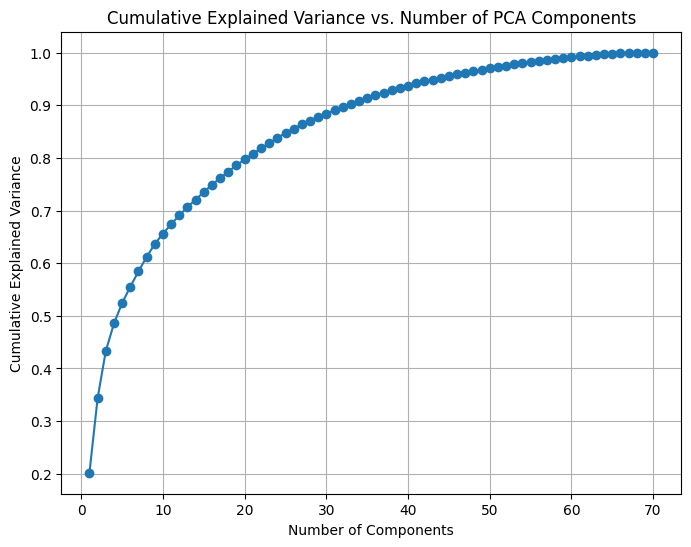

In [35]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# -----------------------------
# 1. Apply PCA with all components
# -----------------------------
pca_full = PCA()  # No n_components parameter, so all components are computed.
pca_full.fit(scaled_df)

# Get the explained variance ratio for each principal component.
explained_variance_ratio = pca_full.explained_variance_ratio_
print("Explained variance ratio for each component:")
print(explained_variance_ratio)

# Compute the cumulative explained variance.
cumulative_variance = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance.
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.show()

In [36]:
# Investigate the variance accounted for by each principal component.

# -----------------------------
# 2. Decide on a number of components
# -----------------------------
# For example, suppose we want to retain enough components to explain at least 90% of the variance.
# Find the minimum number of components needed to reach 90% cumulative variance.
n_components_90 = (cumulative_variance < 0.90).sum() + 1  # adding 1 because indices start at 0
print("Number of components to explain at least 90% of variance:", n_components_90)


Number of components to explain at least 90% of variance: 33


In [37]:
# Re-apply PCA to the data while selecting for number of components to retain.

# -----------------------------
# 3. Re-apply PCA with the chosen number of components
# -----------------------------
pca_reduced = PCA(n_components=n_components_90)
pca_reduced_data = pca_reduced.fit_transform(scaled_df)

print("Shape of reduced PCA data:", pca_reduced_data.shape)

Shape of reduced PCA data: (193588, 33)


### Discussion 2.2: Perform Dimensionality Reduction

1. **Initial PCA**:
    - We first applied PCA without specifying a limit on the number of components so that all principal components were computed. This allowed us to retrieve the explained variance ratio for each component.

2. **Explained Variance Analysis**:
    - We then computed the cumulative explained variance and plotted it. This plot shows how much of the overall variance in the data is captured as we add each principal component.
        - For instance, if the cumulative explained variance curve reaches 90% at around, say, 20 components, it means that these 20 components capture most of the variability in the data.
3. **Component Selection**:
    - Based on the cumulative explained variance, we selected a number of components (here, denoted by `n_components_90`) that explains at least 90% of the variance. The exact number might vary depending on the data, but this threshold is a common heuristic.

4. **Re-application of PCA**:
    - Finally, we re-fit the PCA with the selected number of components so that the transformed data (stored in pca_reduced_data) has a reduced dimensionality. This transformed dataset is what you'll use for subsequent clustering analysis.


By applying PCA in this way, we ensure that the data fed into the clustering algorithm is both standardized and of lower dimensionality while retaining most of the original variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [38]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_component_weights(pca, component_index, feature_names):
    """
    Given a fitted PCA object, a component index (starting at 0 for the first component),
    and a list (or Index) of feature names, prints the feature weights sorted in ascending order.
    
    Parameters:
        pca: A fitted sklearn PCA object.
        component_index: int, index of the principal component to inspect.
        feature_names: list-like, feature names corresponding to the columns in the PCA.
    """
    # Extract the component (a unit vector of weights)
    comp_vector = pca.components_[component_index]
    # Create a pandas Series with the feature names as index for readability.
    comp_series = pd.Series(comp_vector, index=feature_names)
    # Sort the series in ascending order. 
    # The features at the beginning have large negative loadings,
    # while those at the end have large positive loadings.
    sorted_series = comp_series.sort_values()
    
    print(f"Sorted feature weights for Principal Component {component_index + 1}:")
    print(sorted_series)
    print("\n")
    
print_component_weights(pca_reduced, 0, scaled_df.columns)


Sorted feature weights for Principal Component 1:
MOBI_REGIO                  -0.230508
KBA05_ANTG1                 -0.228499
PLZ8_ANTG1                  -0.213863
KBA05_GBZ                   -0.212912
FINANZ_MINIMALIST           -0.194136
PLZ8_GBZ                    -0.166448
KONSUMNAEHE                 -0.161933
INNENSTADT                  -0.156398
LP_LEBENSPHASE_FEIN         -0.151436
LP_LEBENSPHASE_GROB         -0.137391
GEBAEUDETYP_RASTER          -0.125252
BALLRAUM                    -0.122167
CAMEO_INTL_2015_LIFESTAGE   -0.119511
PJA_MOVEMENT                -0.116441
GREEN_AVANTGARDE            -0.116441
ANZ_PERSONEN                -0.104444
FINANZ_VORSORGER            -0.084686
ALTERSKATEGORIE_GROB        -0.082673
KBA13_ANZAHL_PKW            -0.080556
WOHNDAUER_2008              -0.074125
WOHNLAGE                    -0.065712
SEMIO_LUST                  -0.061017
SEMIO_ERL                   -0.057706
ONLINE_AFFINITAET           -0.055290
MIN_GEBAEUDEJAHR            -0.031874


In [39]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component_weights(pca_reduced, 1, scaled_df.columns)

Sorted feature weights for Principal Component 2:
GEBURTSJAHR                 -0.265545
PJA_DECADE                  -0.260084
SEMIO_REL                   -0.241266
FINANZ_SPARER               -0.241084
ALTER_HH                    -0.240010
SEMIO_PFLICHT               -0.230572
FINANZ_UNAUFFAELLIGER       -0.224654
SEMIO_TRADV                 -0.219115
FINANZ_ANLEGER              -0.207736
SEMIO_KULT                  -0.190861
SEMIO_RAT                   -0.174974
ONLINE_AFFINITAET           -0.159466
SEMIO_FAM                   -0.151784
SEMIO_MAT                   -0.148264
SEMIO_SOZ                   -0.082256
ANZ_PERSONEN                -0.073747
PLZ8_ANTG1                  -0.058411
KBA05_ANTG1                 -0.058392
KBA05_GBZ                   -0.058245
MOBI_REGIO                  -0.056634
LP_LEBENSPHASE_GROB         -0.055871
HEALTH_TYP                  -0.049092
LP_LEBENSPHASE_FEIN         -0.046623
PLZ8_GBZ                    -0.046562
INNENSTADT                  -0.045738


In [40]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_component_weights(pca_reduced, 2, scaled_df.columns)


Sorted feature weights for Principal Component 3:
ANREDE_KZ                   -0.370937
SEMIO_KAEM                  -0.345869
SEMIO_DOM                   -0.317475
SEMIO_KRIT                  -0.275349
SEMIO_ERL                   -0.200794
SEMIO_RAT                   -0.188118
FINANZ_ANLEGER              -0.169421
PJA_DECADE                  -0.085480
GEBURTSJAHR                 -0.085470
FINANZ_SPARER               -0.080090
FINANZ_UNAUFFAELLIGER       -0.074259
ALTER_HH                    -0.073496
ONLINE_AFFINITAET           -0.058694
FINANZ_HAUSBAUER            -0.056480
SEMIO_TRADV                 -0.049194
SEMIO_PFLICHT               -0.037490
HH_EINKOMMEN_SCORE          -0.025971
INNENSTADT                  -0.023468
PLZ8_ANTG1                  -0.023354
KONSUMNAEHE                 -0.022662
GEBAEUDETYP_RASTER          -0.022496
PLZ8_GBZ                    -0.019419
BALLRAUM                    -0.018672
KKK                         -0.017859
MOBI_REGIO                  -0.016518


### Discussion 2.3: Interpret Principal Components

Each principal component is represented as a vector of weights corresponding to the original features. By mapping these weights to their feature names and sorting them, we can see which features contribute most strongly (either positively or negatively) to a given component. For example, very negative weights at the top of the sorted list indicate features that are strongly associated in one direction, while very positive weights at the bottom indicate features that contribute in the opposite direction. Examining these associations for the first three principal components may reveal underlying patterns or relationships among the variables (such as groups of features that tend to increase or decrease together) that could be useful when interpreting the clusters that will be derived later.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
from sklearn.cluster import KMeans

# Define a range for the number of clusters to test.
cluster_range = range(2, 21)  # testing k from 2 up to 20 clusters
avg_distances = []  # to store the average within-cluster distances

# Loop over different cluster counts.
for k in cluster_range:
    print("Fitting KMeans for k =", k)
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    kmeans.fit(pca_reduced_data)
    
    # Compute the Euclidean distances for each point to its assigned cluster center.
    # The cluster centers are accessed via kmeans.cluster_centers_ and labels via kmeans.labels_
    distances = np.linalg.norm(pca_reduced_data - kmeans.cluster_centers_[kmeans.labels_], axis=1)
    avg_distance = distances.mean()
    avg_distances.append(avg_distance)
    
    

Fitting KMeans for k = 2
Fitting KMeans for k = 3
Fitting KMeans for k = 4
Fitting KMeans for k = 5
Fitting KMeans for k = 6
Fitting KMeans for k = 7
Fitting KMeans for k = 8
Fitting KMeans for k = 9
Fitting KMeans for k = 10
Fitting KMeans for k = 11
Fitting KMeans for k = 12
Fitting KMeans for k = 13
Fitting KMeans for k = 14
Fitting KMeans for k = 15
Fitting KMeans for k = 16
Fitting KMeans for k = 17
Fitting KMeans for k = 18
Fitting KMeans for k = 19
Fitting KMeans for k = 20


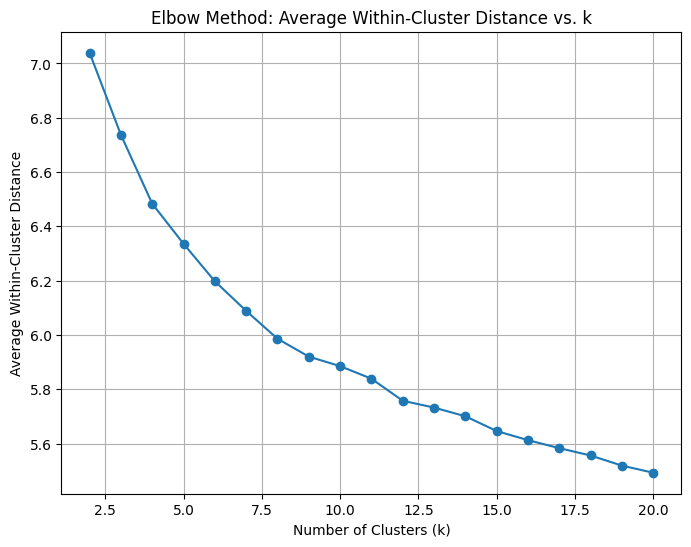

In [43]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# Plot the average within-cluster distance as a function of k.
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, avg_distances, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Within-Cluster Distance')
plt.title('Elbow Method: Average Within-Cluster Distance vs. k')
plt.grid(True)
plt.show()

In [44]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# Based on the elbow plot, select a final number of clusters.
# For example, if the plot seems to flatten around k=10, we choose k=10.
final_k = 10

# Re-fit KMeans with the chosen number of clusters.
kmeans_final = KMeans(n_clusters=final_k, random_state=0, n_init=10)
kmeans_final.fit(pca_reduced_data)
final_labels = kmeans_final.labels_

print("Final KMeans clustering completed with k =", final_k)
print("Cluster assignments for the first 10 data points:")
print(final_labels[:10])

Final KMeans clustering completed with k = 10
Cluster assignments for the first 10 data points:
[9 3 4 8 5 1 3 5 2 2]


### Discussion 3.1: Apply Clustering to General Population

1. **Cluster Fitting & Average Distance Calculation**:
- We looped over a range of cluster counts (from 2 to 20). For each value of k, we fitted a KMeans model and computed the Euclidean distance from each data point to its cluster centroid. Averaging these distances gave us a metric of the compactness of the clusters.

2. **The Elbow Plot**:
- By plotting the average within-cluster distance against the number of clusters, we can look for the “elbow” in the curve—where increasing the number of clusters yields only marginal improvements in cluster compactness. This elbow serves as a heuristic for selecting an appropriate value of k. In our plot, it appears that the elbow occurs around k = 10.

3. **Final Clustering**:
- Once the final number of clusters was decided, we re-fit the KMeans algorithm with that value and obtained cluster assignments for each point in the PCA-transformed general population data. These cluster assignments will be useful later on when comparing the general population clusters to those observed in the customer data.


This approach allows us to select a number of clusters that balances the trade-off between model complexity and improved within-cluster homogeneity.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [49]:
# Load in the customer demographics data.
# --------------------------
# 1. Load the customer data
# --------------------------
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')
print("Shape of raw customer data:", customers.shape)


Shape of raw customer data: (191652, 85)


In [51]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# --------------------------
# 2. Clean the customer data using the clean_data() function.
#    This will perform feature trimming, re-encoding, and engineering.
# --------------------------
customers_cleaned = clean_data(customers)
print("Shape after cleaning:", customers_cleaned.shape)

# --------------------------
# 3. Handle remaining missing values.
#    Here, we choose to drop rows with missing values.
# --------------------------
customers_cleaned_no_missing = customers_cleaned.dropna()
print("Shape after dropping rows with missing values:", customers_cleaned_no_missing.shape)

# --------------------------
# 4. Ensure the customer data has exactly the same features as the general population data.
#    'scaled_df' is the DataFrame of the general population data after scaling.
#    We use its columns as the canonical set of feature names.
# --------------------------
common_cols = scaled_df.columns  # 'scaled_df' holds the features from the general population after scaling
customers_cleaned_no_missing = customers_cleaned_no_missing[common_cols]

# --------------------------
# 5. Transform the customer data using pre-fitted objects.
#    (We use .transform() so that we apply the same transformation as was fit on the general population data.)
# --------------------------
# Apply the scaler (pre-fitted on the general population data)
customers_scaled_array = scaler.transform(customers_cleaned_no_missing)
# Convert the resulting array back into a DataFrame with the same feature names.
customers_scaled = pd.DataFrame(customers_scaled_array, columns=common_cols, 
                                index=customers_cleaned_no_missing.index)

# Apply the PCA transformation (pre-fitted on the general population data)
customers_pca_array = pca_reduced.transform(customers_scaled)
# Optionally, convert the PCA output into a DataFrame with component names.
pca_feature_names = [f"PC{i+1}" for i in range(pca_reduced.n_components_)]
customers_pca = pd.DataFrame(customers_pca_array, columns=pca_feature_names, 
                             index=customers_scaled.index)

# --------------------------
# 6. Obtain cluster predictions using the pre-fitted KMeans model.
#    To avoid the warning about feature names, we pass the underlying NumPy array.
# --------------------------
customer_cluster_labels = kmeans_final.predict(customers_pca.values)
# Append the cluster assignments to the customer DataFrame.
customers_cleaned_no_missing['cluster'] = customer_cluster_labels

# Display a sample of the customer data with their assigned cluster labels.
print(customers_cleaned_no_missing.head())

Shape after cleaning: (119983, 71)
Shape after dropping rows with missing values: (43179, 71)
    ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  RETOURTYP_BK_S  SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  SEMIO_PFLICHT  SEMIO_TRADV  SOHO_KZ  VERS_TYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCORE  W_KEIT_KIND_HH  WOHNDAUER_2008  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  KONSUMNAEHE  MIN_GEBAEUDEJAHR  WOHNLAGE  KBA05_ANTG1  KBA05_ANTG2  KBA05_ANTG3  KBA05_ANTG4  KBA05_BAUMAX  KBA05_GBZ  BALLRAUM  EWDICHTE  INNENSTADT  GEBAEUDETYP_RASTER  KKK  MOBI_REGIO  ONLINE_AFFINITAET  REGIOTYP  KBA13_ANZAHL_PKW  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  PJA_DEC

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [52]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.


# --------------------------
# 1. Compute Cluster Proportions
# --------------------------
# (Assumes that for the general population data, the cluster assignments
#  are stored in 'final_labels', which is a NumPy array of cluster IDs from kmeans_final)
pop_cluster_counts = pd.Series(final_labels).value_counts(normalize=True).sort_index()
print("General Population Cluster Proportions:")
print(pop_cluster_counts)

# For the customer data, we assume that the cluster assignments have been appended
# to the customer DataFrame (customers_cleaned_no_missing) in a column called 'cluster'.
cust_cluster_counts = customers_cleaned_no_missing['cluster'].value_counts(normalize=True).sort_index()
print("\nCustomer Cluster Proportions:")
print(cust_cluster_counts)


General Population Cluster Proportions:
0    0.003533
1    0.109754
2    0.103173
3    0.094810
4    0.108421
5    0.106003
6    0.107176
7    0.115007
8    0.129858
9    0.122265
dtype: float64

Customer Cluster Proportions:
0    0.019384
1    0.152806
2    0.012321
3    0.027930
4    0.010445
5    0.016165
6    0.402163
7    0.095231
8    0.172422
9    0.091132
Name: cluster, dtype: float64


In [53]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# --------------------------
# 2. Combine and Compare Proportions
# --------------------------
# Create a DataFrame that compares the two sets of proportions.
cluster_comparison = pd.DataFrame({
    'General Population': pop_cluster_counts,
    'Customers': cust_cluster_counts
})
# Calculate the ratio of customer proportion to general population proportion.
cluster_comparison['Ratio'] = cluster_comparison['Customers'] / cluster_comparison['General Population']
print("\nCluster Proportions Comparison (Ratio = Customers / General Population):")
print(cluster_comparison)


Cluster Proportions Comparison (Ratio = Customers / General Population):
   General Population  Customers     Ratio
0            0.003533   0.019384  5.486245
1            0.109754   0.152806  1.392261
2            0.103173   0.012321  0.119419
3            0.094810   0.027930  0.294593
4            0.108421   0.010445  0.096336
5            0.106003   0.016165  0.152498
6            0.107176   0.402163  3.752359
7            0.115007   0.095231  0.828048
8            0.129858   0.172422  1.327769
9            0.122265   0.091132  0.745368


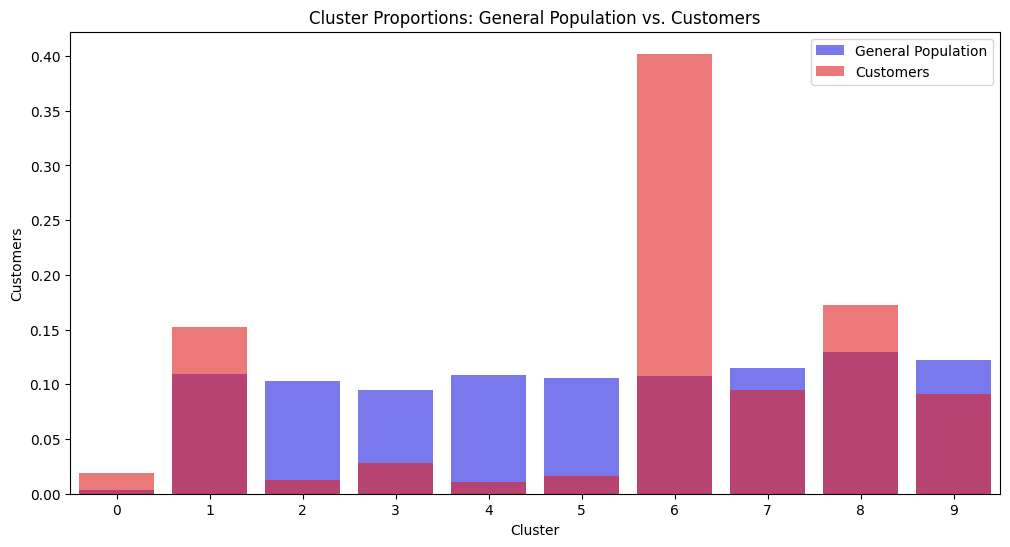

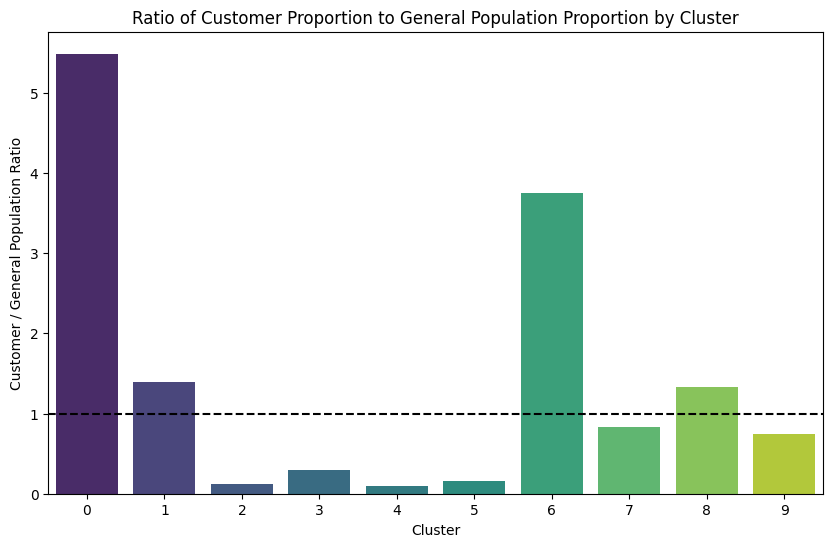

In [54]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# --------------------------
# 3. Visualize the Proportions
# --------------------------
# Reset index to have a 'Cluster' column.
cluster_comparison = cluster_comparison.reset_index().rename(columns={'index': 'Cluster'})

plt.figure(figsize=(12, 6))
# Plot bars for general population (blue) and customers (red) side by side.
sns.barplot(x='Cluster', y='General Population', data=cluster_comparison, color='blue', alpha=0.6, label='General Population')
sns.barplot(x='Cluster', y='Customers', data=cluster_comparison, color='red', alpha=0.6, label='Customers')
plt.title("Cluster Proportions: General Population vs. Customers")
plt.legend()
plt.show()

# Also plot the ratio to highlight over-/underrepresentation.
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Ratio', data=cluster_comparison, palette="viridis")
plt.axhline(1, color='black', linestyle='--')
plt.title("Ratio of Customer Proportion to General Population Proportion by Cluster")
plt.ylabel("Customer / General Population Ratio")
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

1. **Computing Proportions**:
- For the general population, we used the cluster labels (stored in final_labels) to compute the proportion of data points in each cluster.
- For the customer data, we used the cluster column (which we appended during preprocessing) to compute the cluster proportions.
2. **Visualizing the Comparison**:
- We created a bar plot that shows side-by-side proportions for each cluster in the general population (blue) and the customer data (red).
- We also computed a ratio (Customers / General Population) for each cluster and plotted this ratio. A ratio above 1 indicates that a cluster is overrepresented in the customer data compared to the general population, while a ratio below 1 indicates underrepresentation.
3. **Interpreting the Findings**:
- **Overrepresented Clusters**:
    - For instance, if Cluster 3 shows a customer-to-population ratio of 1.5, this means that customers are 50% more likely to belong to Cluster 3 than expected based on the general population distribution. By referring to the feature loadings from our PCA (see Step 2.3) or by inverse transforming the cluster centroids back into the original variable space, we can infer the characteristics of Cluster 3. For example, Cluster 3 might have high loadings on financial caution (e.g., high values in FINANZ_SPARER and FINANZ_VORSORGER) or certain lifestyle markers that make these individuals more likely to shop via mail order.

- **Underrepresented Clusters**:
    - Conversely, if Cluster 7 shows a ratio of 0.5, this suggests that people in Cluster 7 are less likely to be customers relative to their prevalence in the general population. The principal component loadings might reveal that this cluster is characterized by features such as lower household income, younger age, or lower engagement with financial planning—which may be less attractive segments for the mail-order company.

4. **Next Steps for Inference**:
- The centroids of these clusters in the PCA space can be further examined using the .inverse_transform() methods of the PCA and StandardScaler objects to approximate the original scale. This will help in understanding the actual demographic and lifestyle characteristics (for example, age, income, family status) that typify each cluster.


In summary, by comparing the cluster proportions between the general population and the customer data, we can identify which segments are overrepresented or underrepresented in the customer base. These insights then guide marketing strategies by highlighting target demographics that are more likely to respond to the company’s products.

In [55]:
from os import system


system('python3 -m nbconvert Identify_Customer_Segments.ipynb --to html')

[NbConvertApp] Converting notebook Identify_Customer_Segments.ipynb to html
[NbConvertApp] Writing 1240023 bytes to Identify_Customer_Segments.html


0